In [1]:
import time
import numpy as np
import dxchange
from utils import nor_phase
from ganrec2 import GANphase
import os
from lib import visualize
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from ganrec1 import *
import skimage.io as io

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)



/beegfs/desy/user/hailudaw/anacon/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, MaxPooling2D, UpSampling2D, concatenate, Dense, Conv2D, Conv2DTranspose, \
    Flatten, concatenate, \
        BatchNormalization, Dropout, \
            ReLU,LeakyReLU, Add, Activation

def tfnor_phase(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    return img

from tensorflow.keras.models import Model, Sequential, load_model

def dense_norm(units, dropout, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Dense(units, 
            #   activation=tf.nn.tanh, 
              use_bias=True, 
              kernel_initializer=initializer))
    result.add(Dropout(dropout))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def conv2d_norm(filters, size, strides, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2D(filters, 
               size, 
               strides=strides, 
               padding='same',
               kernel_initializer=initializer, 
               use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def dconv2d_norm(filters, size, strides, apply_dropout=False):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2DTranspose(filters, 
                        size, 
                        strides=strides,
                        padding='same',
                        kernel_initializer=initializer,
                        use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.25))

    result.add(LeakyReLU())

    return result


def make_generator_atan(img_h, img_w, conv_num, conv_size, dropout, output_num):
    units = 128
    fc_size = img_h * img_w
    inputs = Input(shape=(img_h, img_w, 1))
    x = Flatten()(inputs)
    fc_stack = [
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(fc_size, 0),
    ]

    conv_stack = [
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size, 1),
    ]

    dconv_stack = [
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]
    last_1 = conv2d_norm(output_num + 1, 3, 1)
    last = conv2d_norm(output_num, 3, 1)

    def tanh_on_first_two(x):
        x = Activation('tanh')(x[:, :, :, :2])
        return tf.reshape(x, [1, img_h, img_w, 2])
    
    def relu_on_last(x):
        x = Activation('relu')(x[:, :, :, 2])
        return tf.reshape(x, [1, img_h, img_w, 1])
    
    def only_layer(x, i):
        return tf.reshape(x[:, :, :, i], [1, img_h, img_w, 1])

    for fc in fc_stack:
        x = fc(x)

    x = tf.reshape(x, shape=[-1, img_h, img_w, 1])
    # Convolutions
    for conv in conv_stack:
        x = conv(x)
        
    for dconv in dconv_stack:
        x = dconv(x)

    if output_num > 2:
        x = last_1(x)
        x = [tanh_on_first_two(x), only_layer(x, 2)]
        phase = tf.atan2(x[0][0, :, :, 0], x[0][0, :, :, 1])
        phase = (tf.reshape(phase, [1, img_h, img_w, 1]))
        absorption = (tf.reshape((x[1][0, :, :, 0]), [1, img_h, img_w, 1]))
        x = tf.concat([phase, absorption], axis=3)

    x = last(x)
    if output_num == 2:
        model = Model(inputs=inputs, outputs=x)
    else:
        model = Model(inputs=inputs, outputs=x)
        # model = Model(inputs=inputs, outputs=[(tf.reshape(Activation('tanh')(x[0, :, :, :2]), [1, img_h, img_w, 2])), (tf.reshape((x[0, :, :, 2]), [1, img_h, img_w, 1]))])
    return model



def make_generator(img_h, img_w, conv_num, conv_size, dropout, output_num):
    units = 128
    fc_size = img_h * img_w
    inputs = Input(shape=(img_h, img_w, 1))
    x = Flatten()(inputs)
    fc_stack = [
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(fc_size, 0),
    ]

    conv_stack = [
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size, 1),
    ]

    dconv_stack = [
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]

    last = conv2d_norm(output_num, 3, 1)

    for fc in fc_stack:
        x = fc(x)

    x = tf.reshape(x, shape=[-1, img_h, img_w, 1])
    # Convolutions
    for conv in conv_stack:
        x = conv(x)
        
    for dconv in dconv_stack:
        x = dconv(x)
    x = last(x)

    model = Model(inputs=inputs, outputs=x)
    return model


def make_generator_rev(img_h, img_w, conv_num, conv_size, dropout, output_num):
    units = 128
    fc_size = img_h * img_w
    inputs = Input(shape=(img_h, img_w, 1))

    fc_stack = [
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(fc_size, 0),
    ]

    conv_stack = [
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size, 1),

    ]

    dconv_stack = [
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]

    
    last_1 = conv2d_norm(1, 3, 1)
    last = conv2d_norm(output_num, 3, 1)
    
    #model structure
    x = conv2d_norm(conv_num, conv_size+2, 1)(inputs)
    for conv in conv_stack:
        x = conv(x)

    for dconv in dconv_stack:
        x = dconv(x)
    x = dconv2d_norm(conv_num, conv_size+2, 1)(x)
    
    x = last_1(x)
    x = Flatten()(x)

    for fc in fc_stack:
        x = fc(x)
    x = tf.reshape(x, shape=[-1, img_h, img_w, 1])

    x = last(x)    
    model = Model(inputs=inputs, outputs=x) 
    return model


def make_filter(img_h, img_w):
    inputs = Input(shape=[img_h, img_w, 1])
    down_stack = [
        conv2d_norm(16, 3, 1),  # (batch_size, 128, 128, 64)
        conv2d_norm(16, 3, 1)
    ]

    up_stack = [

        dconv2d_norm(16, 3, 1),  # (batch_size, 128, 128, 128)
        dconv2d_norm(16, 3, 1)
    ]
    last = conv2d_norm(1, 3, 1)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)


def make_discriminator(nang, px):
    model = Sequential()
    model.add(Conv2D(16, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[nang, px, 1]))
    model.add(Conv2D(16, (5, 5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1))

    return model

def unet(img_h, img_w, output_num = 2, depth=4, conv_num=64, conv_size=3):
    inputs = Input(shape=(img_h, img_w, 1))
    conv_stack = [
        conv2d_norm(conv_num, conv_size, 1),
        conv2d_norm(conv_num*2, conv_size, 1),
        conv2d_norm(conv_num*3, conv_size, 1),
        conv2d_norm(conv_num*4, conv_size, 1),
    ]

    dconv_stack = [
        dconv2d_norm(conv_num*3, conv_size, 1),
        dconv2d_norm(conv_num*2, conv_size, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]

    up = UpSampling2D(size=(2, 2))
     
    down = MaxPooling2D(pool_size=(2, 2))
    last = conv2d_norm(output_num, conv_size, 1)

    #model structure
    x = inputs
    for conv in conv_stack:
        x = conv(x)
        x = down(x)

    for dconv in dconv_stack:
        x = up(x)
        x = dconv(x)

    x = last(x)

    #to original size
    x = UpSampling2D(size=(2, 2))(x)
    model = Model(inputs=inputs, outputs=x)
    print(model.summary())
    return model


In [12]:
import tensorflow as tf
from tensorflow_addons.image import median_filter2d

import numpy as np

# from models import *
from utils import *

from joblib import Parallel, delayed


# @tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output,
                                                                       labels=tf.ones_like(real_output)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                       labels=tf.zeros_like(fake_output)))
    total_loss = real_loss + fake_loss
    return total_loss

def l1_loss(img1, img2):
    return tf.reduce_mean(tf.abs(img1 - img2))
def l2_loss(img1, img2):
    return tf.square(tf.reduce_mean(tf.abs(img1-img2)))

# @tf.function
def generator_loss(fake_output, img_output, pred, l1_ratio):
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                      labels=tf.ones_like(fake_output))) \
               + l1_loss(img_output, pred) * l1_ratio
    return gen_loss

# @tf.function
def filer_loss(fake_output, img_output, img_filter):
    f_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                    labels=tf.ones_like(fake_output))) + \
              l1_loss(img_output, img_filter) *10
              # l1_loss(img_output, img_filter) * 10
    return f_loss


def tfnor_tomo(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    img = img - tf.reduce_min(img)
    # img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    return img


def tfnor_phase(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    return img

def tfnor_diff(img):
    # img = tf.image.per_image_standardization(img)
    # img = img / tf.reduce_max(img)
    # img = img - tf.reduce_min(img)
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    return img

def avg_results(recon, loss):
    sort_index = np.argsort(loss)
    recon_tmp = recon[sort_index[:10], :, :, :]
    return np.mean(recon_tmp, axis=0)

def phase_fresnel(phase, absorption, ff, px):
    paddings = tf.constant([[px // 2, px // 2], [px // 2, px // 2]])
    # padding1 = tf.constant([[px // 2, px // 2], [0, 0]])
    # padding2 = tf.constant([[0, 0], [px // 2, px // 2]])
    pvalue = tf.reduce_mean(phase[:100, :])
    # phase = tf.pad(phase, paddings, 'CONSTANT',constant_values=1)
    phase = tf.pad(phase, paddings, 'SYMMETRIC')
    # phase = tf.pad(phase, paddings, 'REFLECT')
    absorption = tf.pad(absorption, paddings, 'SYMMETRIC')
    # phase = phase
    # absorption = absorption
    abfs = tf.complex(-absorption, phase)
    abfs = tf.exp(abfs)
    ifp = tf.abs(tf.signal.ifft2d(ff * tf.signal.fft2d(abfs))) ** 2
    ifp = tf.reshape(ifp, [ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.central_crop(ifp, 0.5)
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    # ifp = tfnor_phase(ifp)
    return ifp

def phase_fresnel_2(cosine, sine, absorption, ff, px):
    paddings = tf.constant([[px // 2, px // 2], [px // 2, px // 2]])
    # padding1 = tf.constant([[px // 2, px // 2], [0, 0]])
    # padding2 = tf.constant([[0, 0], [px // 2, px // 2]])
    pvalue = tf.reduce_mean(cosine[:100, :])
    # phase = tf.pad(phase, paddings, 'CONSTANT',constant_values=1)
    cosine = tf.pad(cosine, paddings, 'SYMMETRIC')
    sine = tf.pad(sine, paddings, 'SYMMETRIC')
    # phase = tf.pad(phase, paddings, 'REFLECT')
    absorption = tf.pad(absorption, paddings, 'SYMMETRIC')
    # abfs = #amplitude * (cosine - i * sine)
    abfs = tf.complex(tf.exp(-1*absorption) * cosine, tf.exp(-1*absorption)  * sine)
    # abfs = tf.complex(-absorption, phase)
    # abfs = tf.exp(abfs)
    ifp = tf.abs(tf.signal.ifft2d(ff * tf.signal.fft2d(abfs))) ** 2
    ifp = tf.reshape(ifp, [ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.central_crop(ifp, 0.5)
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    # ifp = tfnor_phase(ifp)
    return ifp

def phase_fraunhofer(phase, absorption):
    wf = tf.complex(absorption, phase)
    # wf = tf.complex(phase, absorption)

    # wf = mask_img(wf)
    # wf = tf.multiply(ampl, tf.exp(phshift))
    # wf = tf.manip.roll(wf, [160, 160], [0, 1])
    ifp = tf.square(tf.abs(tf.signal.fft2d(wf)))
 
    
    # # adding log to the fft
    # ifp = tf.math.log(ifp+8000)
    ifp = tf.math.log(ifp+10000)
    # ifp = tf.math.log(tf.abs(tf.signal.fft2d(wf))+1)
    # ifp = tf.math.log(tf.square(tf.abs(tf.signal.fft2d(wf)))+1)
    ifp = tf.signal.fftshift(ifp)
  
    # ifp = tf.roll(ifp, [256, 256], [0, 1])
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tfnor_diff(ifp)
    return ifp


def diffusion_layer(input_tensor, sigma=1.0):
    size = int(sigma*4)
    x = tf.linspace(-3.0, 3.0, size)
    z = (1.0/(sigma*tf.sqrt(2.0*3.1415)))*tf.exp(-tf.square(x)/(2.0*sigma*sigma))
    z_2d = tf.matmul(tf.reshape(z, [size, 1]), tf.reshape(z, [1, size]))
    z_4d = tf.reshape(z_2d, [size, size, 1, 1])
    return tf.nn.depthwise_conv2d(input_tensor, z_4d, [1, 1, 1, 1], 'SAME')

class GANphase:
    def __init__(self, i_input, energy, z, pv, **kwargs):
        phase_args = _get_GANphase_kwargs()
        phase_args.update(**kwargs)
        super(GANphase, self).__init__()
        self.i_input = i_input
        self.px, self.py = i_input.shape
        self.energy = energy
        self.z = z
        self.pv = pv
        self.internal_iter = kwargs['internal_iter']
        self.last_retrieval = kwargs['last_retrieval']
        self.iter_num = phase_args['iter_num']
        self.conv_num = phase_args['conv_num']
        self.conv_size = phase_args['conv_size']
        self.dropout = phase_args['dropout']
        self.l1_ratio = phase_args['l1_ratio']
        self.abs_ratio = phase_args['abs_ratio']
        self.g_learning_rate = phase_args['g_learning_rate']
        self.d_learning_rate = phase_args['d_learning_rate']
        self.phase_only = phase_args['phase_only']
        self.save_wpath = phase_args['save_wpath']
        self.init_wpath = phase_args['init_wpath']
        self.init_model = phase_args['init_model']
        self.save_model = phase_args['save_model']
        self.recon_monitor = phase_args['recon_monitor']
        self.filter_type = phase_args['filter_type']
        self.output_num = phase_args['output_num']
        self.filter = None
        self.generator = None
        self.discriminator = None
        self.filter_optimizer = None
        self.generator_optimizer = None
        self.discriminator_optimizer = None

    def make_model(self):
        self.filter = make_filter(self.i_input.shape[0],
                                  self.i_input.shape[1])
        self.generator = make_generator_atan(self.i_input.shape[0],
                                        self.i_input.shape[1],
                                        self.conv_num,
                                        self.conv_size,
                                        self.dropout,
                                        self.output_num)
        self.discriminator = make_discriminator(self.i_input.shape[0],
                                                self.i_input.shape[1])
        self.filter_optimizer = tf.keras.optimizers.Adam(5e-3)
        self.generator_optimizer = tf.keras.optimizers.Adam(self.g_learning_rate)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(self.d_learning_rate)

    def make_chechpoints(self):
        checkpoint_dir = '/data/ganrec/training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

    @tf.function
    def rec_step(self, i_input, ff, phase_input = None, absorption_input = None):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            recon = self.generator(i_input)
        
            #change from list to tensor
            if type(recon) == list:
                print(len(recon), recon[0].shape, recon[1].shape)
                sin_phase = recon[0][0, :, :, 0]
                cos_phase = recon[0][0, :, :, 1]
                
                phase = tf.reshape(tf.atan2(sin_phase, cos_phase), [1, self.px, self.py,1])
                absorption = (1 - tfnor_phase(tf.reshape(recon[1][0, :, :, 0], [1, self.px, self.py, 1])) )* self.abs_ratio
            
                phase = tf.reshape((phase), [self.px, self.py])
                absorption = tf.reshape((absorption), [self.px, self.py])
                # i_rec = phase_fresnel(phase, absorption, ff, self.px)
                i_rec = phase_fresnel_2(cos_phase, sin_phase, absorption, ff, self.px)
            else:   
                phase = tfnor_phase(tf.reshape(recon[:, :, :, 0], [1, self.px, self.py, 1]))
                absorption = (1 - tfnor_phase(tf.reshape(recon[:, :, :, 1], [1, self.px, self.py, 1])) )* self.abs_ratio
                phase = tf.reshape(phase, [self.px, self.py])
                absorption = tf.reshape((1- absorption) * self.abs_ratio, [self.px, self.py])
            
                if self.phase_only:
                    absorption = tf.zeros_like(phase)
                i_rec = phase_fresnel(phase, absorption, ff, self.px)
            # i_rec = phase_fresnel_2(tf.reshape((recon[:, :, :, 0]), [self.px, self.py]), tf.reshape((recon[:, :, :, 1]), [self.px, self.py]), tf.reshape(tfnor_phase(recon[:, :, :, 2]), [self.px, self.py]), ff, self.px)
        

            real_output = self.discriminator(i_input, training=True)
            fake_output = self.discriminator(i_rec, training=True)
            if phase_input is not None and absorption_input is not None:
                #change their shape
                phase_input = tf.reshape(phase_input, [1, self.px, self.py, 1])
                absorption_input = tf.reshape(absorption_input, [1, self.px, self.py, 1])
                phase = tf.reshape(phase, [1, self.px, self.py, 1])
                absorption = tf.reshape(absorption, [1, self.px, self.py, 1])
                #discremenate between the real phase and the generated phase, and the real absorption and the generated absorption and the real intensity and the generated intensity
                real_output_phase = self.discriminator(phase_input, training=True)
                fake_output_phase = self.discriminator(phase, training=True)
                real_output_abs = self.discriminator(absorption_input, training=True)
                fake_output_abs = self.discriminator(absorption, training=True)
                real_output_i = self.discriminator(i_input, training=True)
                fake_output_i = self.discriminator(i_rec, training=True)
                # fake_output_i_2 = self.discriminator(i_rec_2, training=True)

                g_loss = generator_loss(fake_output_i, i_input, i_rec, self.l1_ratio) + \
                            generator_loss(fake_output_phase, phase_input, phase, self.l1_ratio) + \
                            generator_loss(fake_output_abs, absorption_input, absorption, self.l1_ratio)
                            # generator_loss(fake_output_i_2, i_input, i_rec_2, self.l1_ratio)
                            
                
                d_loss = discriminator_loss(real_output, fake_output) + \
                        discriminator_loss(real_output_phase, fake_output_phase) + \
                            discriminator_loss(real_output_abs, fake_output_abs) + \
                            discriminator_loss(real_output_i, fake_output_i)
                                # discriminator_loss(real_output_i, fake_output_i_2)
                    
                
            else:
                g_loss = generator_loss(fake_output, i_input, i_rec, self.l1_ratio)
                d_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(g_loss,
                                                   self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(d_loss,
                                                        self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                     self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                         self.discriminator.trainable_variables))
        


        return {'phase':  tf.reshape(phase, [self.px, self.py]),
                'absorption': tf.reshape(absorption, [self.px, self.py]),
                'i_rec': i_rec,
                'g_loss': g_loss,
                'd_loss': d_loss,
                'recon': recon}


    def multi_propagation(self, i_input, ffs, retrieved_phase = None, retrieved_absorption = None, filter_type = None):
        if retrieved_phase is not None and retrieved_absorption is not None:
            if filter_type is None:
                filter_type = self.filter_type

            if filter_type == 'median':
                # filter the phase and absorption
                filtered_phase = median_filter2d( tf.reshape(retrieved_phase, [1, self.px, self.py, 1]))[0, :, :, 0]
                filtered_absorption = median_filter2d( tf.reshape(retrieved_absorption, [1, self.px, self.py, 1]))[0, :, :, 0]
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            if filter_type == 'contrast':
                # add contrast to the phase and absorption
                filtered_phase = (retrieved_phase - tf.reduce_min(retrieved_phase))/ (tf.reduce_max(retrieved_phase) - tf.reduce_min(retrieved_phase))
                filtered_absorption = (retrieved_absorption - tf.reduce_min(retrieved_absorption))/ (tf.reduce_max(retrieved_absorption) - tf.reduce_min(retrieved_absorption))
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            
            if filter_type == 'noise':
                # add noise to the phase and absorption
                filtered_phase = retrieved_phase + tf.random.normal(retrieved_phase.shape, mean=0.0, stddev=0.1, dtype=tf.float32)
                filtered_absorption = retrieved_absorption + tf.random.normal(retrieved_absorption.shape, mean=0.0, stddev=0.1, dtype=tf.float32)
                step_results = [self.rec_step(phase_fresnel(filtered_phase, filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phase, absorption_input = filtered_absorption) for i in range(1, len(ffs))]
            if filter_type == 'diffuse':
                # diffuse
                # ffs = [ffs[0]]*5
                sigma_coeff = list(np.arange(0.9, 1.1, 0.2))
                ffs = [ffs[0]]*len(sigma_coeff)
                filtered_phases = [diffusion_layer(tf.reshape(retrieved_phase, [1, self.px, self.py, 1]), sigma=sigma_coeff[i])[0, :, :, 0] for i in range(len(sigma_coeff))]
                filtered_absorptions = [diffusion_layer(tf.reshape(retrieved_absorption, [1, self.px, self.py, 1]), sigma=sigma_coeff[i])[0, :, :, 0] for i in range(len(sigma_coeff))]
                step_results = [self.rec_step(phase_fresnel(filtered_phases[i], filtered_absorptions[i], ffs[0], self.px), ffs[0], phase_input = filtered_phases[i], absorption_input = filtered_absorptions[i]) for i in range(len(sigma_coeff))]
            if filter_type == 'phase_only':
                # diffuse
                sigma_coeff = list(np.arange(0.5, 0.5*len(ffs), 0.5))
                filtered_phases = [diffusion_layer(tf.reshape(retrieved_phase, [1, self.px, self.py, 1]), sigma=sigma_coeff[i])[0, :, :, 0] for i in range(len(sigma_coeff))]
                filtered_absorption = np.zeros_like(filtered_phases[0])
                step_results = [self.rec_step(phase_fresnel(filtered_phases[i], filtered_absorption, ffs[i], self.px), ffs[i], phase_input = filtered_phases[i], absorption_input = filtered_absorption) for i in range(len(sigma_coeff))]
            if filter_type == 'alternate':
                step_results = [self.rec_step(phase_fresnel(retrieved_phase, retrieved_absorption, ffs[i], self.px), ffs[i], phase_input = retrieved_phase, absorption_input = retrieved_absorption) for i in range(1, len(ffs))]                
        else:
            step_results = self.rec_step(i_input, ffs[0])
        return step_results
    
    @property
    def recon(self):
        ff = ffactor(self.px * 2, self.py *2, self.energy, self.z, self.pv)
        ffs = []
        
        ffs.append(ff)
        # for i in range(1, self.internal_iter):
            # z_i = self.z * (1 + 1/i)
            # ffs.append(ffactor(self.px * 2, self.py *2, self.energy, z_i, self.pv))
        for i in range(1, self.internal_iter):
            z_i = self.z / (1 + 1/i)
            ffs.append(ffactor(self.px * 2, self.py *2, self.energy, z_i, self.pv))
        ffs.append(ff)
        # print(ff.shape, ff.max(), ff.min())

        i_input = np.reshape(self.i_input, (1, self.px, self.py, 1))
        i_input = tf.cast(i_input, dtype=tf.float32)
        self.make_model()

        if self.init_model:
            self.generator.load_weights(self.init_wpath+'generator.h5')
            print('generator is initilized')
            self.discriminator.load_weights(self.init_wpath+'discriminator.h5')
            print('discriminator is initilized')

        phase = np.zeros((self.iter_num, self.px, self.py))
        absorption = np.zeros((self.iter_num, self.px, self.py))
        gen_loss = np.zeros(self.iter_num)
        i_rec_all = np.zeros((self.iter_num, self.px, self.py))

        ###########################################################################
        # Reconstruction process monitor
        
        plot_x, plot_loss = [], []
        if self.recon_monitor:
            recon_monitor = RECONmonitor('phase')
            recon_monitor.initial_plot(self.i_input)

        side_propagation = []
        ###########################################################################
        for epoch in range(self.iter_num):

            ###########################################################################
            ## Call the rconstruction step
            
            step_results = self.rec_step(i_input, ffs[0])
            side_propagation.append(step_results['recon'])
            # print('epoch: {}, g_loss: {}, d_loss: {}'.format(epoch, step_results['g_loss'], step_results['d_loss']))

            if self.last_retrieval:
                if epoch % 100 == 0:
                    retrieved_phase = step_results['phase']
                    retrieved_absorption = step_results['absorption']
                    step_result_i = self.multi_propagation(i_input, ffs, retrieved_phase, retrieved_absorption, filter_type = self.filter_type)
                    # step_result_i = self.rec_step(median_filter2d(i_input), ff)    
                
            phase[epoch, :, :] = step_results['phase']
            absorption[epoch, :, :] = step_results['absorption']
            i_rec = step_results['i_rec']
            i_rec_all[epoch, :, :] = np.reshape(i_rec, (self.px, self.py))
            gen_loss[epoch] = step_results['g_loss']
            d_loss = step_results['d_loss']
            ###########################################################################
                
            plot_x.append(epoch)
            plot_loss = gen_loss[:epoch + 1]

            if (epoch + 1) % 41 == 0:
                # checkpoint.save(file_prefix=checkpoint_prefix)
                if self.recon_monitor:  
                    i_rec = np.reshape(i_rec, (self.px, self.py))
                    i_diff = np.abs(i_rec - self.i_input.reshape((self.px, self.py)))
                    phase_plt = np.reshape(phase[epoch], (self.px, self.py))
                    recon_monitor.update_plot(epoch, i_diff, phase_plt, plot_x, plot_loss)
        if self.recon_monitor:
            recon_monitor.close_plot()

        if self.save_model:
            self.generator.save(self.save_wpath+'generator.h5')
            self.discriminator.save(self.save_wpath+'discriminator.h5')

        return absorption[epoch], phase[epoch], i_rec_all[epoch], gen_loss[epoch], side_propagation



def train(data, energy, z, pv, abs_ratio, iter_num,  idx, phase_only = False, recon_monitor = True, **kwargs):
    import time
    import os
    import dxchange
    from ganrec_dataloader import measure_reconstruction_quality, tf_reshape, tfback_phase

    if type(data) is not list:
        px = data.shape[0]
        py = data.shape[1]
        kwargs['px'] = px
        kwargs['py'] = py
        gan_phase_object = GANphase(data, energy, z, pv, 
                                    abs_ratio = abs_ratio, 
                                    iter_num = iter_num,
                                    phase_only=phase_only,
                                    recon_monitor = True, **kwargs)
        start = time.time()
        absorption, phase, i_rec_all, gen_loss, side_propagation = gan_phase_object.recon
        end = time.time()
        save_wpath = kwargs['save_wpath']
        if save_wpath is not None:
            #if path does not exist, create it
            if not os.path.exists(save_wpath):
                os.makedirs(save_wpath)
                os.makedirs(save_wpath+'/abs/')
                os.makedirs(save_wpath+'/phase/')
                os.makedirs(save_wpath+'/propagation/')
                os.makedirs(save_wpath+'/gen_loss/')

            dxchange.write_tiff(absorption, save_wpath+'abs/abs{}'.format(idx))
            dxchange.write_tiff(phase, save_wpath+'phase/phase_{}'.format(idx))
            dxchange.write_tiff(i_rec_all, save_wpath+'propagation/propagation{}'.format(idx))
            np.save(save_wpath+'gen_loss/gen_loss_{}'.format(idx), gen_loss)    
            
            # matched = tfback_phase(tf_reshape(i_rec_all), tf_reshape(data[idx]))
            # time_count = np.array([end-start])
            # df = measure_reconstruction_quality(img1=tf_reshape(i_rec_all), img2 = tf_reshape(data), experiment_name = 'reconstructed'+str(idx)+'_'+str(abs_ratio), csv_file = 'Vojtech_fixed.csv', iteration = kwargs['iter_num'], save = True, epoch_time = time_count[0], total_time = np.sum(time_count))
            # print(df)
        return absorption, phase, i_rec_all, gen_loss, side_propagation
    else:
        px = data[0].shape[0]
        py = data[0].shape[1]
        kwargs['px'] = px
        kwargs['py'] = py
        absorption = np.zeros((len(data), px, py))
        phase = np.zeros((len(data), px, py))
        i_rec_all = np.zeros((len(data), px, py))
        gen_loss = np.zeros((len(data), iter_num))
        side_propagation = []
        for i in range(len(data)):
            gan_phase_object = GANphase(data[i], energy, z, pv, 
                                        abs_ratio = abs_ratio, 
                                        iter_num = iter_num,
                                        phase_only=phase_only,
                                        recon_monitor = True, **kwargs)
            start = time.time()
            absorption[i], phase[i], i_rec_all[i], gen_loss[i], side_propagation = gan_phase_object.recon
            end = time.time()
            save_wpath = kwargs['save_wpath']
            if save_wpath is not None:
                #if path does not exist, create it
                if not os.path.exists(save_wpath):
                    os.makedirs(save_wpath)
                    os.makedirs(save_wpath+'/abs/')
                    os.makedirs(save_wpath+'/phase/')
                    os.makedirs(save_wpath+'/propagation/')
                    os.makedirs(save_wpath+'/gen_loss/')

                dxchange.write_tiff(absorption[i], save_wpath+'abs/abs{}'.format(idx))
                dxchange.write_tiff(phase[i], save_wpath+'phase/phase_{}'.format(idx))
                dxchange.write_tiff(i_rec_all[i], save_wpath+'propagation/propagation{}'.format(idx))
                np.save(save_wpath+'gen_loss/gen_loss_{}'.format(idx), gen_loss[i])
            # matched = tfback_phase(tf_reshape(i_rec_all[i]), tf_reshape(data[i]))
            # time_count = np.array([end-start])
            # df = measure_reconstruction_quality(img1=tf_reshape(i_rec_all[i]), img2 = tf_reshape(data[i]), experiment_name = 'reconstructed'+str(idx)+'_'+str(abs_ratio), csv_file = 'Vojtech_fixed.csv', iteration = kwargs['iter_num'], save = True, epoch_time = time_count[0], total_time = np.sum(time_count))
        return absorption, phase, i_rec_all, gen_loss, side_propagation


def _get_GANphase_kwargs():
    return{
        'iter_num': 1000,
        'conv_num': 32,
        'conv_size': 3,
        'dropout': 0.25,
        'l1_ratio': 10,
        'abs_ratio': 0.05,
        'g_learning_rate': 1e-3,
        'd_learning_rate': 1e-5,
        'phase_only': False,
        'save_wpath': None,
        'init_wpath': None,
        'init_model': True,
        'save_model': False,
        'recon_monitor': False,
        'output_num': 2,
    }

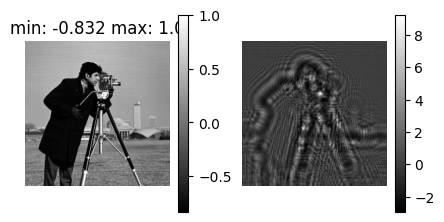

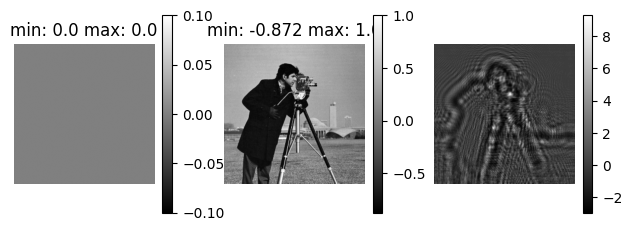

                                                               0
experiment_name                                spider_hair_0_0.0
iter                                                       10000
sum of pointwise difference                             0.000044
sum of absolute value of pointwise difference            2.45461
sum of squared difference                               0.042008
PSNR                                                  [37.84911]
SSIM                                                 [0.9899561]
NRMSE                                                   0.204958
MSSIM                                               [0.99964637]
epoch_time                                            209.189873
total_time                                            209.189873


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.2767,0.2768,0.2769,0.2770,0.2771,0.2772,0.2773,0.2774,0.2775,0
experiment_name,spider_hair_0_0.005,spider_hair_0_0.001,spider_hair_0_0.01,spider_hair_0_0.1,spider_hair_0_0.005,spider_hair_1_0.005,spider_hair_2_0.005,spider_hair_3_0.005,spider_hair_4_0.005,spider_hair_5_0.005,...,spider_hair_0_0.0,spider_hair_0_0.0,spider_hair_0_0.0,spider_hair_0_0.0,spider_hair_0_0.0,spider_hair_0_0.0,spider_hair_0_0.0,spider_hair_0_0.0,spider_hair_0_0.0,spider_hair_0_0.0
iter,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,5000,5000,5000,5000,5000,5000,1000,1000,1000,10000
sum of pointwise difference,1.0678117,1.0677754,1.0677476,1.0681081,1.0675116,1.7406926,5.294111,4.6951256,-2.0370803,-0.76821685,...,2.6622787e-05,-1.6614795e-06,-2.2388995e-05,-8.363277e-07,2.6101246e-05,4.6417117e-05,3.1769276e-05,-1.6212463e-05,-1.66893e-06,0.000044
sum of absolute value of pointwise difference,27.055195,26.410727,19.84621,17.291338,17.791815,33.992867,31.49842,31.038956,31.634548,33.0773,...,7.0582237,5.8386116,5.422933,3.132286,3.027347,2.8229952,19.647263,14.696569,17.238144,2.45461
sum of squared difference,5.6280355,5.884934,3.3873558,2.4756074,2.4831715,9.0479965,7.518339,7.4791965,8.405365,9.745775,...,0.33262995,0.3424273,0.3383969,0.077413216,0.077079654,0.0604041,4.547126,2.3065872,2.5032916,0.042008
PSNR,[19.58913],[19.395283],[21.794092],[23.155882],[23.142632],[17.527176],[18.331478],[18.354149],[17.847134],[17.204535],...,[28.862785],[28.736713],[28.788134],[35.194244],[35.213],[36.271732],[17.50503],[20.4527],[20.097284],[37.84911]
SSIM,[0.89393246],[0.842487],[0.93475425],[0.9483144],[0.93816346],[0.735249],[0.80681175],[0.85031],[0.8700472],[0.8572213],...,[0.98172164],[0.94808465],[0.96244615],[0.98293966],[0.99093616],[0.98607755],[0.8422285],[0.90056795],[0.8874009],[0.9899561]
NRMSE,2.372348,2.4258883,1.840477,1.5734063,1.5758082,3.0079887,2.7419589,2.734812,2.8992007,3.1218224,...,0.5767408,0.5851729,0.5817189,0.2782323,0.27763224,0.24577245,2.132399,1.5187453,1.5821793,0.204958
MSSIM,[0.98695135],[0.9543729],[0.9928939],[0.9946718],[0.99315494],[0.8924219],[0.9378776],[0.97340477],[0.97980803],[0.97619706],...,[0.9991718],[0.99161977],[0.9883853],[0.99913865],[0.9995673],[0.99925417],[0.9644995],[0.9771931],[0.9800161],[0.99964637]
epoch_time,[77.765144],[61.675625],[57.26491],[61.144947],[80.770164],[80.770164],[80.770164],[80.770164],[80.770164],[80.770164],...,124.05047512054443,118.67952799797058,115.6531445980072,106.63191175460815,108.67924380302429,115.14922380447388,28.829365730285645,27.309601545333862,24.001420974731445,209.189873


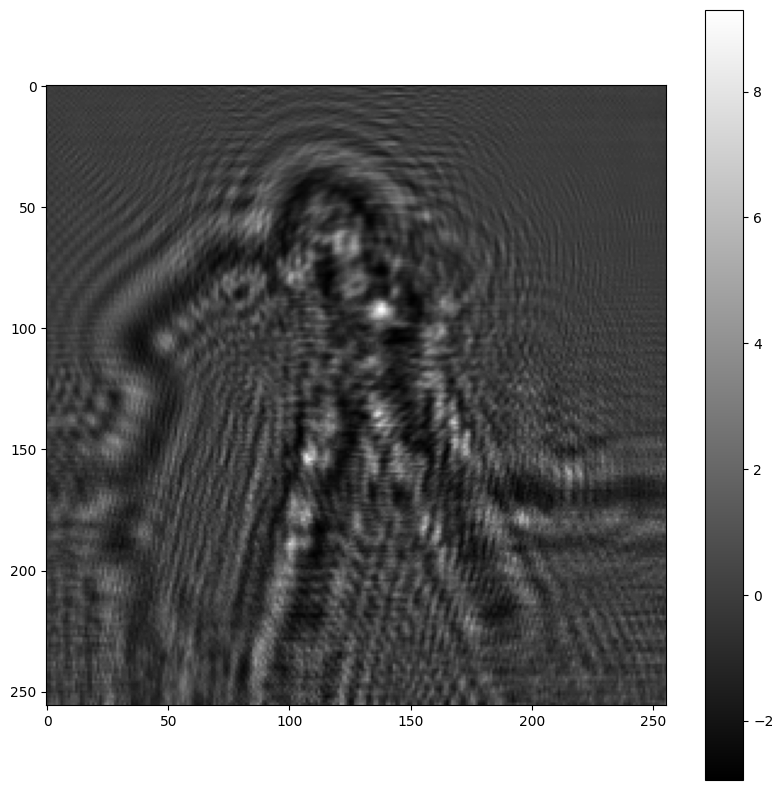

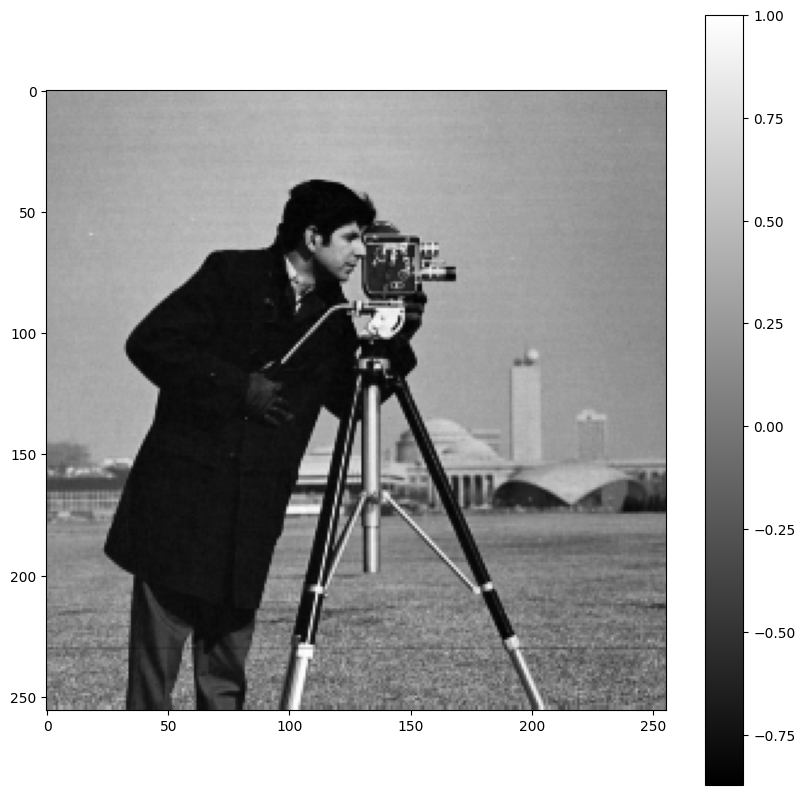

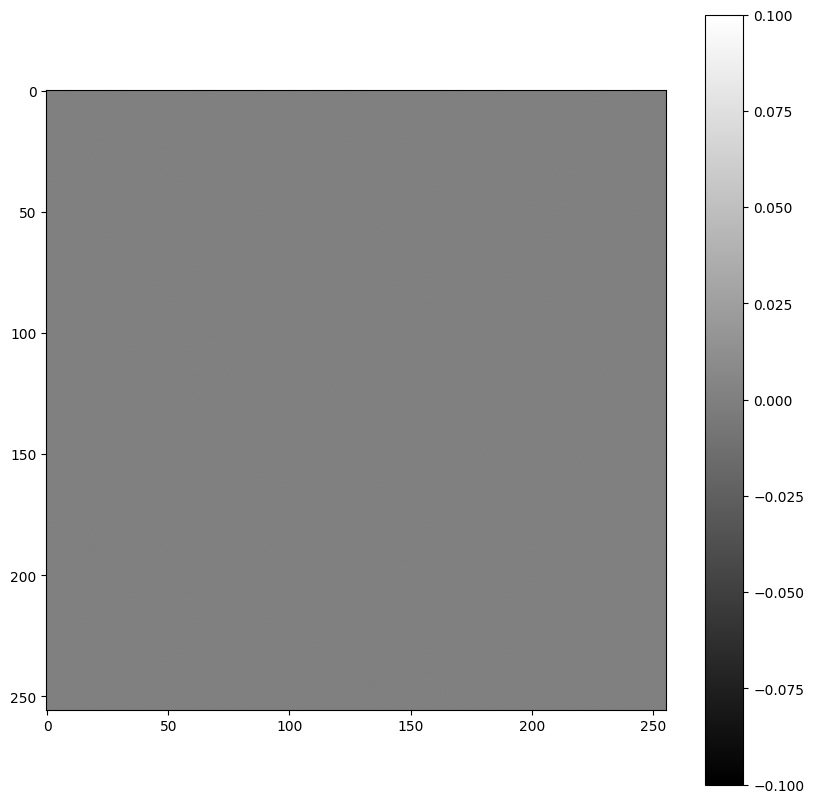

In [17]:
from ganrec_dataloader import measure_reconstruction_quality, tf_reshape, tfback_phase
#Barbara data
cameraman_tes_image =nor_phase(dxchange.read_tiff('data/cameraman.tif'))/np.max(nor_phase(dxchange.read_tiff('data/cameraman.tif')))
import quantities as pq
energy = 10.8 * pq.keV
lam = wavelength_from_energy(energy)
fresnel_nummber = 0.005 * pq.dimensionless
z = 1.0 * pq.meter
pv = np.sqrt(fresnel_nummber * lam * z) #array(8.39314161e-06) * m
px, py = cameraman_tes_image.shape
kwargs = {}
kwargs['iter_num'] = 10000
kwargs['internal_iter'] = 3
kwargs['last_retrieval'] = False
kwargs['save_wpath'] = 'data/gan_phase/cameraman/'
kwargs['init_wpath'] = 'data/gan_phase/cameraman/'
kwargs['init_model'] = False
kwargs['save_model'] = False
kwargs['filter_type'] = 'noise' #chose from median, contrast, noise, diffuse, phase_only, alternate
kwargs['output_num'] = 2
kwargs['energy'] = energy.magnitude
kwargs['z'] = z.magnitude
kwargs['pv'] = pv.magnitude
kwargs['phase_only'] = True
kwargs['recon_monitor'] = False
kwargs['abs_ratio'] = 0
kwargs['dropout'] = 0.25
kwargs['idx'] = 0
abs_ratio_all = 0 * np.ones(1)
absorption = np.zeros((len(abs_ratio_all), px, py))
phase = np.zeros((len(abs_ratio_all), px, py))
propagated = np.zeros((len(abs_ratio_all), px, py))
loss = np.zeros(len(abs_ratio_all))
side_propagations = []
time_count = np.zeros(len(abs_ratio_all))

given_phase = cameraman_tes_image
cos, sin = np.cos(given_phase), np.sin(given_phase)
given_absorption = np.zeros_like(cameraman_tes_image)

ff = ffactor(px * 2, py *2, kwargs['energy'], kwargs['z'], kwargs['pv'])
propagated_image = phase_fresnel(given_phase, given_absorption, ff, px)[0, :, :, 0]
visualize([cameraman_tes_image, propagated_image])

#propagation with cos and sin
propagated_image = phase_fresnel_2(cos, sin, given_absorption, ff, px)[0, :, :, 0]


for i, abs_ratio in enumerate(abs_ratio_all):
    idx = i
    gan_phase_object = GANphase(propagated_image, **kwargs)
    start = time.time()
    absorption[i], phase[i],propagated[i], loss[i], side_propagation  = gan_phase_object.recon
    side_propagations.append(side_propagation)
    end = time.time()
    time_count[i] = end - start
    # matched = tfback_phase( propagated[i], cameraman_tes_image[idx])
    visualize([absorption[i], phase[i], propagated[i]])#, matched, data[idx], idx, abs_ratio, kwargs['iter_num'])
    # io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/phase/phase_'+str(idx)+'_'+str(abs_ratio)+'.tif', phase[i])
    # io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])
    # io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/propagated/propagated_'+str(idx)+'_'+str(abs_ratio)+'.tif', propagated[i])
    df = measure_reconstruction_quality(img1=tf_reshape(propagated[i]), img2 = tf_reshape(propagated_image), experiment_name = 'spider_hair_'+str(idx)+'_'+str(abs_ratio), csv_file = 'Vojtech_fixed.csv', iteration = kwargs['iter_num'], save = True, epoch_time = time_count[0], total_time = np.sum(time_count))
    display(df)

visualize(propagated)
visualize(phase)
visualize(absorption)

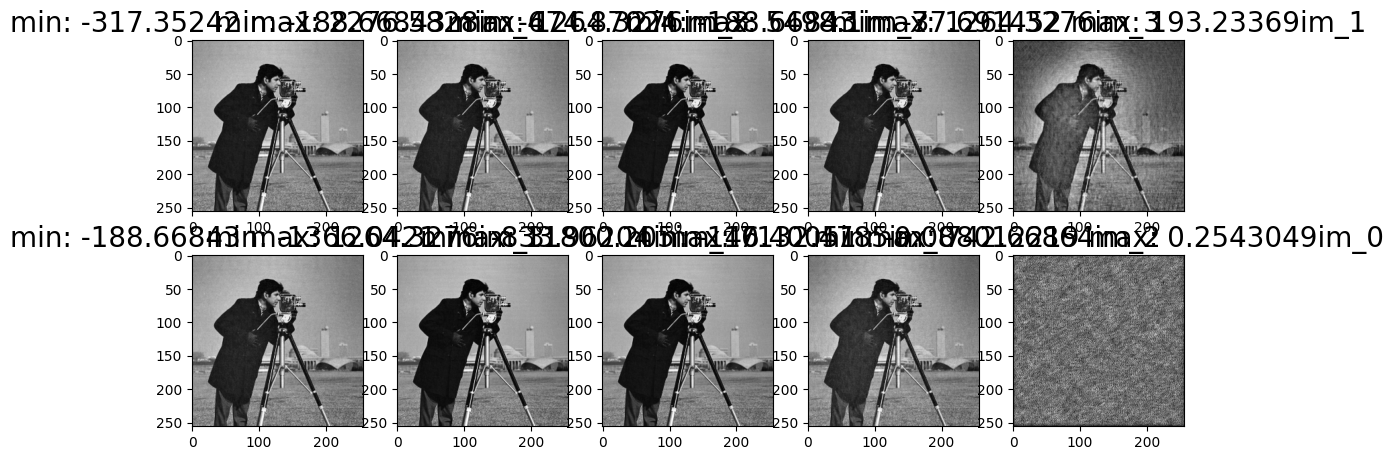

In [54]:
from lib import plot_or_show_images
plot_or_show_images([side_propagation[0][0,:,:,0], side_propagation[100][0,:,:,0], side_propagation[1000][0,:,:,0], side_propagation[2000][0,:,:,0], side_propagation[3000][0,:,:,0], side_propagation[4000][0,:,:,0], side_propagation[5000][0,:,:,0], side_propagation[6000][0,:,:,0], side_propagation[7000][0,:,:,0], side_propagation[8000][0,:,:,0], side_propagation[9000][0,:,:,0], side_propagation[9999][0,:,:,0]], rows =2 , figsize = [90,90], show_or_plot = "show")

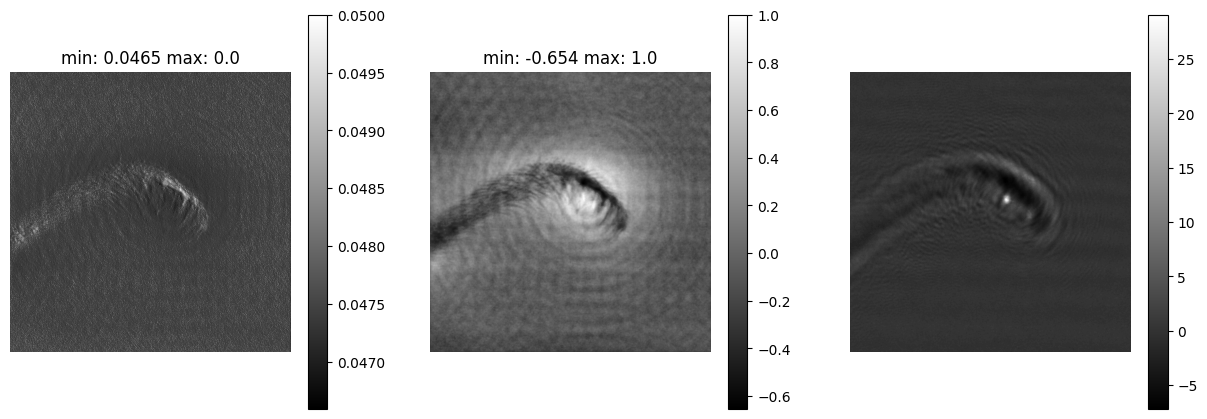

                                                                   0
experiment_name                                spider_hair_126_0.001
iter                                                             200
sum of pointwise difference                                 9.509277
sum of absolute value of pointwise difference              90.577446
sum of squared difference                                 105.542061
PSNR                                                     [6.8584437]
SSIM                                                     [0.5554283]
NRMSE                                                      10.273366
MSSIM                                                     [0.841995]
epoch_time                                                [17.18438]
total_time                                                  17.18438


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.2753,0.2754,0.2755,0.2756,0.2757,0.2758,0.2759,0.2760,0.2761,0
experiment_name,spider_hair_0_0.005,spider_hair_0_0.001,spider_hair_0_0.01,spider_hair_0_0.1,spider_hair_0_0.005,spider_hair_1_0.005,spider_hair_2_0.005,spider_hair_3_0.005,spider_hair_4_0.005,spider_hair_5_0.005,...,spider_hair_0_0.0,spider_hair_0_0.0,spider_hair_126_0.001,spider_hair_126_0.001,spider_hair_126_0.001,spider_hair_126_0.001,spider_hair_126_0.001,spider_hair_126_0.001,spider_hair_0_0.0,spider_hair_126_0.001
iter,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,10000,10000,1500,1500,1500,1500,1500,1500,10000,200
sum of pointwise difference,1.0678117,1.0677754,1.0677476,1.0681081,1.0675116,1.7406926,5.294111,4.6951256,-2.0370803,-0.76821685,...,-2.9429793e-05,-6.362796e-06,0.67855006,0.67855036,0.67855024,9.508974,9.508891,9.508906,-1.3271347e-05,9.509277
sum of absolute value of pointwise difference,27.055195,26.410727,19.84621,17.291338,17.791815,33.992867,31.49842,31.038956,31.634548,33.0773,...,9.66202,3.3774245,31.478657,18.11813,16.977226,44.298355,318.66302,355.09198,2.4777322,90.577446
sum of squared difference,5.6280355,5.884934,3.3873558,2.4756074,2.4831715,9.0479965,7.518339,7.4791965,8.405365,9.745775,...,1.0878968,0.07850317,513.1487,512.36237,512.0666,51.94562,572.99524,502.76306,0.042570755,105.542061
PSNR,[19.58913],[19.395283],[21.794092],[23.155882],[23.142632],[17.527176],[18.331478],[18.354149],[17.847134],[17.204535],...,[23.716522],[35.13353],[-0.00973256],[-0.00307261],[-0.0005648],[9.93721],[-0.4888105],[0.07906599],[37.791283],[6.8584437]
SSIM,[0.89393246],[0.842487],[0.93475425],[0.9483144],[0.93816346],[0.735249],[0.80681175],[0.85031],[0.8700472],[0.8572213],...,[0.93939877],[0.98461837],[0.12650494],[0.36676195],[0.43301874],[0.80218935],[0.06952409],[0.05784582],[0.9890229],[0.5554283]
NRMSE,2.372348,2.4258883,1.840477,1.5734063,1.5758082,3.0079887,2.7419589,2.734812,2.8992007,3.1218224,...,1.0430229,0.28018415,22.652784,22.635422,22.628887,7.207331,23.937319,22.422379,0.20632681,10.273366
MSSIM,[0.98695135],[0.9543729],[0.9928939],[0.9946718],[0.99315494],[0.8924219],[0.9378776],[0.97340477],[0.97980803],[0.97619706],...,[0.9933827],[0.9994141],[0.5985225],[0.7500461],[0.7787398],[0.95018625],[0.],[0.],[0.999304],[0.841995]
epoch_time,[77.765144],[61.675625],[57.26491],[61.144947],[80.770164],[80.770164],[80.770164],[80.770164],[80.770164],[80.770164],...,250.36233806610107,242.5070948600769,[102.76277],[101.428215],[100.96734],[97.79372],[97.15568],[101.98632],244.29593324661255,[17.18438]


In [76]:
energy = 11
z = 7.8880960e-2
pv = 1.04735263e-7
iter_num = 700

import dxchange
fname_data = 'data/gan_phase/data_spider.tif'
kwargs = {'energy': energy, 'z': z, 'pv': pv, 'iter_num': iter_num, 'phase_only': False, 'save_wpath': 'data/gan_phase/spider_abs_ratio/', 'init_wpath': 'data/gan_phase/spider_abs_ratio/', 'init_model': False}
data = dxchange.read_tiff(fname_data)
nprj, px,  py = data.shape
data = nor_phase(data)
abs_ratio = 0.01

abs_ratio_all = np.arange(0.01, 10*0.04, 0.004)
abs_ratio_all = 0.001*np.ones(1)

absorption = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
phase = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
propagated = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
loss = np.zeros(shape=(abs_ratio_all.shape[0], kwargs['iter_num']), dtype=np.float32)
time_count = np.zeros(shape=(abs_ratio_all.shape[0], 1), dtype=np.float32)

from ganrec_dataloader import measure_reconstruction_quality, tf_reshape, tfback_phase
kwargs = {}
kwargs['energy'] = energy
kwargs['z'] = z
kwargs['pv'] = pv
kwargs['phase_only'] = False
kwargs['recon_monitor'] = False
kwargs['iter_num'] = 200
kwargs['internal_iter'] = 2
kwargs['last_retrieval'] = False
kwargs['save_wpath'] = 'data/gan_phase/spider_abs_ratio/'
kwargs['init_wpath'] = 'data/gan_phase/spider_abs_ratio/'
kwargs['init_model'] = False
kwargs['save_model'] = False
kwargs['filter_type'] = 'median' #chose from median, contrast, noise, diffuse, phase_only, alternate
kwargs['output_num'] = 3
side_propagations = []


for i, abs_ratio in enumerate(abs_ratio_all):
    idx = i+ 126
    gan_phase_object = GANphase(data[idx], **kwargs)
    start = time.time()
    absorption[i], phase[i],propagated[i], loss[i], side_propagation  = gan_phase_object.recon
    side_propagations.append(side_propagation)
    end = time.time()
    time_count[i] = end - start
    # matched = tfback_phase( propagated[i], data[idx])
    visualize([absorption[i], phase[i], propagated[i]])#, matched, data[idx], idx, abs_ratio, kwargs['iter_num'])
    # io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/phase/phase_'+str(idx)+'_'+str(abs_ratio)+'.tif', phase[i])
    # io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])
    # io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/propagated/propagated_'+str(idx)+'_'+str(abs_ratio)+'.tif', propagated[i])
    df = measure_reconstruction_quality(img1=tf_reshape(propagated[i]), img2 = tf_reshape(data[idx]), experiment_name = 'spider_hair_'+str(idx)+'_'+str(abs_ratio), csv_file = 'Vojtech_fixed.csv', iteration = kwargs['iter_num'], save = True, epoch_time = time_count[0], total_time = np.sum(time_count))
    display(df)

In [44]:
# visualize([side_propagations[0][0][0,:,:,0].numpy()])

#using pandas, analyze the mean, std, min, max of the side propagation
import pandas as pd
analysis = pd.DataFrame({'experiment', 'iteration', 'mean_phase', 'std_phase', 'min_phasee', 'max_phase', 'mean_abs', 'std_abs', 'min_abs', 'max_abs'})
for i in range(len(side_propagations)):
    for iter in range(len(side_propagations[0])):
        #fill the values in the dataframe
        new_pd = pd.DataFrame(columns=['experiment', 'iteration', 'mean_phase', 'std_phase', 'min_phase', 'max_phase', 'mean_abs', 'std_abs', 'min_abs', 'max_abs'])
        new_pd['experiment'] = [i]
        new_pd['iteration'] = [iter]
        new_pd['mean_phase'] = [np.mean(side_propagations[i][iter][0,:,:,0].numpy())]
        new_pd['std_phase'] = [np.std(side_propagations[i][iter][0,:,:,0].numpy())]
        new_pd['min_phase'] = [np.min(side_propagations[i][iter][0,:,:,0].numpy())]
        new_pd['max_phase'] = [np.max(side_propagations[i][iter][0,:,:,0].numpy())]
        new_pd['mean_abs'] = [np.mean(side_propagations[i][iter][0,:,:,1].numpy())]
        new_pd['std_abs'] = [np.std(side_propagations[i][iter][0,:,:,1].numpy())]
        new_pd['min_abs'] = [np.min(side_propagations[i][iter][0,:,:,1].numpy())]
        new_pd['max_abs'] = [np.max(side_propagations[i][iter][0,:,:,1].numpy())]
        analysis = pd.concat([analysis, new_pd], axis=0)
analysis.drop(analysis.columns[0], axis=1, inplace=True)
analysis.dropna(inplace=True)
analysis.to_csv('data/gan_phase/spider_abs_ratio/analysis.csv')


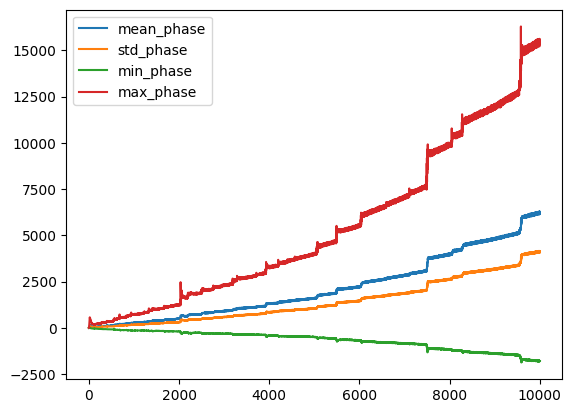

In [45]:
#graph the mean, std, min, max of the side propagation
import matplotlib.pyplot as plt
plt.figure()
plt.plot(analysis['iteration'], analysis['mean_phase'], label='mean_phase')
plt.plot(analysis['iteration'], analysis['std_phase'], label='std_phase')
plt.plot(analysis['iteration'], analysis['min_phase'], label='min_phase')
plt.plot(analysis['iteration'], analysis['max_phase'], label='max_phase')
plt.legend()
plt.savefig('data/gan_phase/spider_abs_ratio/phase_analysis.png')


In [70]:
for_video = tf.concat(side_propagation, axis=0)[:,:,:,0].numpy()

In [63]:
# generate FFmpeg command to make a video from the sequence of images in for_video
fps = 30
command = f"ffmpeg -r {fps} -f image2 -s {px}x{py} -i for_video_%d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p test.mp4"
os.system(command)

sh: ffmpeg: command not found


32512

In [73]:

import ffmpeg
import cv2
images = for_video
height, width, layers = images.shape
size = (width,height)
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(images)):
    out.write(images[i])
out.release()




[mpeg4 @ 0x61c8c240] dimensions too large for MPEG-4
[ERROR:0@8707.319] global cap_ffmpeg_impl.hpp:3049 open Could not open codec mpeg4, error: Unspecified error (-22)
[ERROR:0@8707.319] global cap_ffmpeg_impl.hpp:3066 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter
[ERROR:0@8707.395] global cap.cpp:595 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.7.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): project.avi in function 'icvExtractPattern'




In [ ]:
# visualize([side_propagations[0][50][0,:,:,0].numpy(), side_propagations[0][250][0,:,:,0].numpy(), side_propagations[0][400][0,:,:,0].numpy(), side_propagations[0][490][0,:,:,0].numpy()])
# visualize([side_propagations[0][50][0,:,:,1].numpy(), side_propagations[0][250][0,:,:,1].numpy(), side_propagations[0][400][0,:,:,1].numpy(), side_propagations[0][490][0,:,:,1].numpy()])
# visualize([side_propagations[0][50][0,:,:,2].numpy(), side_propagations[0][250][0,:,:,2].numpy(), side_propagations[0][400][0,:,:,2].numpy(), side_propagations[0][490][0,:,:,2].numpy()])

In [ ]:
# side_propagations[0][50:55][0].shape

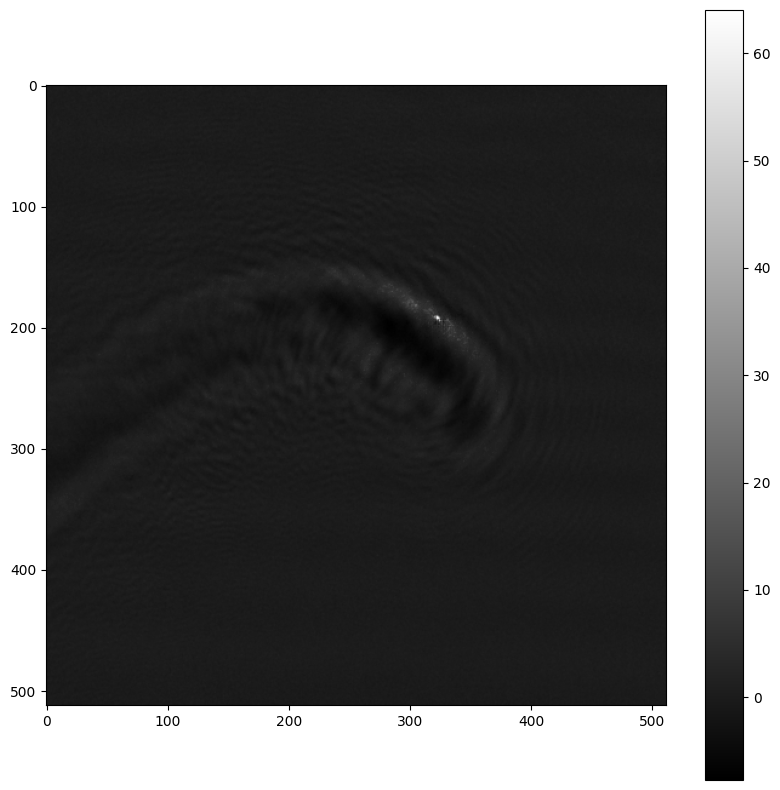

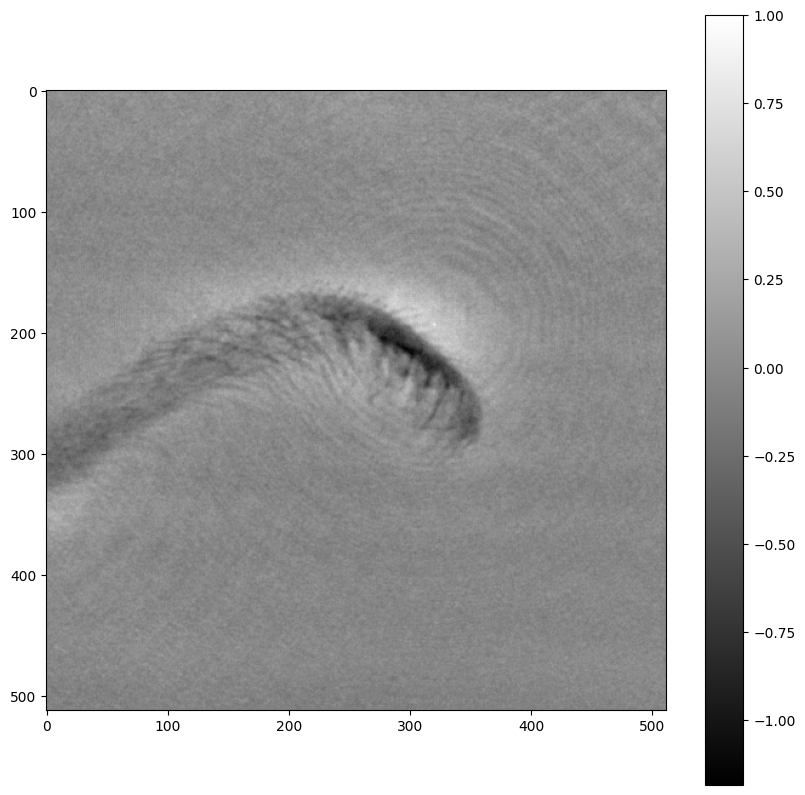

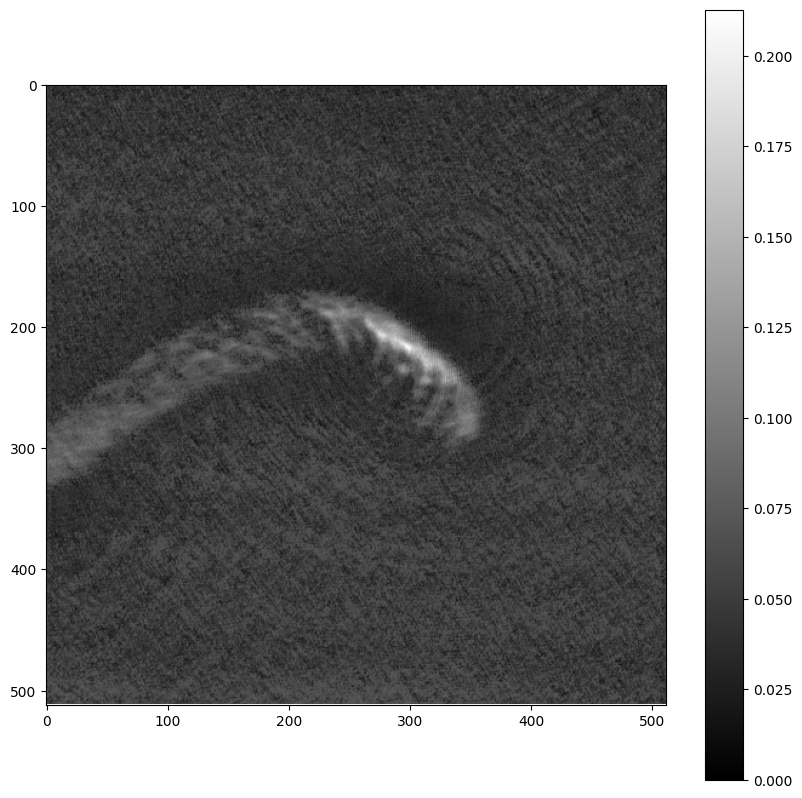

In [13]:
visualize(propagated)
visualize(phase)
visualize(absorption)

In [ ]:
visualize(propagated)
visualize(phase)
visualize(absorption)

In [15]:
visualize_interact(phase)
visualize_interact(absorption)

interactive(children=(Dropdown(description='Show or plot:', options=('show', 'plot'), value='show'), IntSlider…

interactive(children=(Dropdown(description='Show or plot:', options=('show', 'plot'), value='show'), IntSlider…

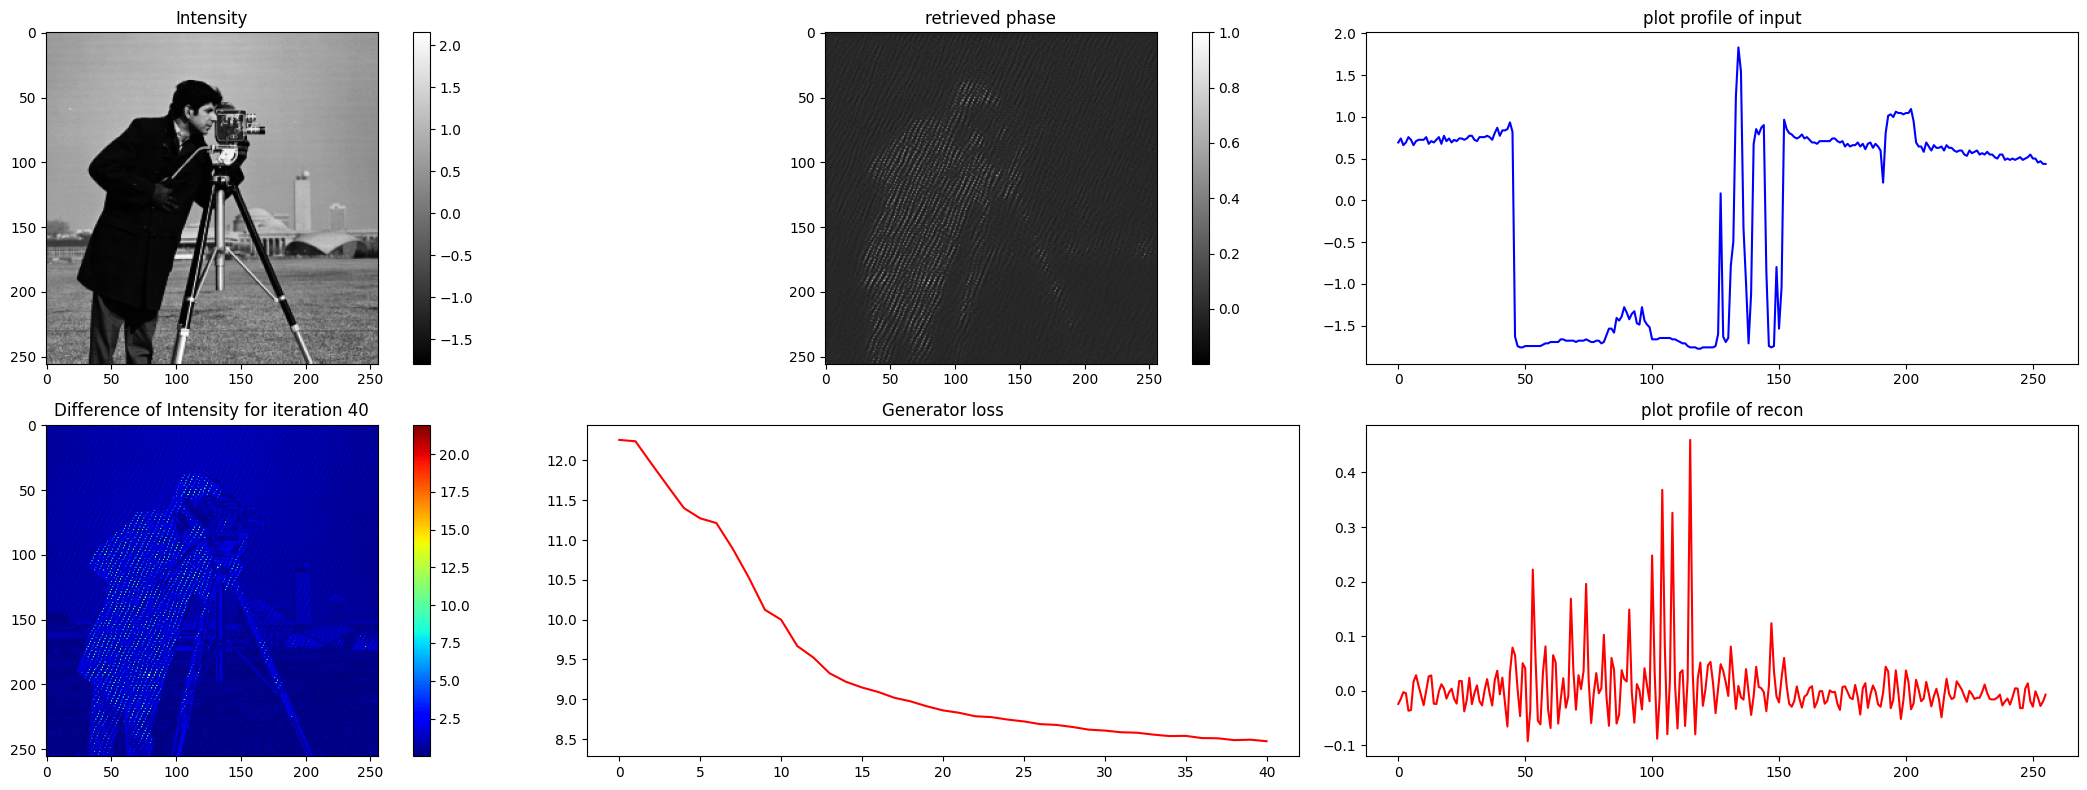

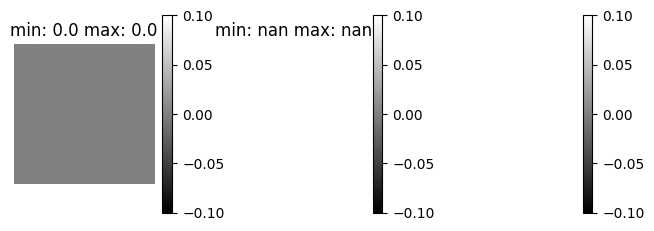

In [45]:
#Barbara data
cameraman_tes_image =nor_phase(dxchange.read_tiff('data/cameraman.tif'))
import quantities as pq
energy = 8.8 * pq.keV
lam = wavelength_from_energy(energy)
fresnel_nummber = 0.5 * pq.dimensionless
z = 1.0 * pq.meter
pv = np.sqrt(fresnel_nummber * lam * z) #array(8.39314161e-06) * m


kwargs['iter_num'] = 10000
kwargs['internal_iter'] = 3
kwargs['last_retrieval'] = False
kwargs['save_wpath'] = 'data/gan_phase/cameraman/'
kwargs['init_wpath'] = 'data/gan_phase/cameraman/'
kwargs['init_model'] = False
kwargs['save_model'] = False
kwargs['filter_type'] = 'median' #chose from median, contrast, noise, diffuse, phase_only, alternate
kwargs['output_num'] = 3
kwargs['energy'] = energy.magnitude
kwargs['z'] = z.magnitude
kwargs['pv'] = pv.magnitude
kwargs['phase_only'] = True
kwargs['recon_monitor'] = False
kwargs['abs_ratio'] = 0
kwargs['dropout'] = 0.25
kwargs['idx'] = 0

absorption, phase, propagated, loss, side_propagation = train(cameraman_tes_image, **kwargs)
visualize([absorption, phase, propagated])


In [ ]:
#